# Mount Drive

In [0]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

# Getting the data

## Raw data

In [0]:
!curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:68.0) Gecko/20100101 Firefox/68.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-datasets/111880/269359/intel-image-classification.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1567087455&Signature=eCAN7FIF6NvpwmwaHqzJZWoeeGFLy5i4YzkXnWw3uAjtdySnAlc7edZlfQ24k0KakZeIOEO5N3mIqHluaZPpMNNOvi7dfO6iF08w%2BdauuBj3naHqoG2iApCIzd9aBiRU9vM1727EuMSOjrsW4IUT8Tg9Hf43DzG38qom9WmHCsjfnmSTiQJlS6JnAIXScX5BkA67hRcYPoLHRLLyzMX5FSuzHxVZDX0vw0aD8kivx2nHC%2BztYVYRfmeJdKiou5K4yicdLcO4a574P27%2BwsCRNKNHW%2FiD3%2FlahkLlHbuut5SZtYDGTOlFMFzUli2wwTYT7EbwF8%2FwBHD5K9YVC4vxCw%3D%3D' --output 'intel-image-classification.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  343M  100  343M    0     0   100M      0  0:00:03  0:00:03 --:--:--  100M


In [0]:
!unzip intel-image-classification.zip

Archive:  intel-image-classification.zip
  inflating: seg_train.zip           
  inflating: seg_test.zip            
  inflating: seg_pred.zip            


In [0]:
!unzip seg_pred.zip
!unzip seg_test.zip
!unzip seg_train.zip

## Data from drive

In [0]:
!cp drive/My\ Drive/datasetintel.tar .

In [0]:
!tar -xvf datasetintel.tar

# Imports

In [0]:
import numpy as np
import pandas as pd
import os
import math
from tqdm.autonotebook import tqdm
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

# Exploring data

In [5]:
print('Classes:')
!ls seg_train/

Classes:
buildings  forest  glacier  mountain  sea  street


In [0]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
img_pred = plt.imread('seg_pred/19527.jpg')
print(f'dimensions of photo: {img_pred.shape}')
img_train = plt.imread('seg_train/buildings/1231.jpg')
img_test = plt.imread('seg_test/buildings/22812.jpg')
ax[0].imshow(img_pred)
ax[1].imshow(img_train)
ax[2].imshow(img_test)
ax[0].set_title('Image pred')
ax[1].set_title('Image train')
ax[2].set_title('Image test')

# DataLoader

In [0]:
class MyDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, path

In [0]:
train_transforms = transforms.Compose([
                                       transforms.RandomHorizontalFlip(),
                                       transforms.Resize((224, 224)),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
])

valid_size = 0.2

trainset = MyDataset('seg_train', transform=train_transforms)
testset = MyDataset('seg_test', transform=test_transforms)

num_test = len(testset)
indices = list(range(num_test))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_test))
test_idx, valid_idx = indices[split:], indices[:split]

test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=12)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, num_workers=12, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, sampler=test_sampler, num_workers=12)

In [0]:
images, labels, path = next(iter(trainloader))
ind = 0
print(f'Length of training dataset: {len(trainset)}')
print(f'Length of validation dataset: {valid_size*len(testset)}')
print(f'Length of test dataset: {(1-valid_size)*len(testset)}')
print(f'Size of images batch: {images.shape}')

image = np.transpose(images[0].numpy(), (1, 2, 0))
plt.imshow(image)
print(labels[ind])

# Model (ResNet50)

In [0]:
model = models.resnet50(pretrained=True)

In [0]:
# Freeze layers here
for param in model.parameters():
    param.requires_grad = False

In [0]:
model.fc = nn.Sequential(nn.Linear(2048, 1024),
                          nn.ReLU(),
                          nn.Linear(1024, 6),
                         nn.LogSoftmax(dim=1))

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
model.cuda()

# Training

In [0]:
def train(model, dataloaders, criterion, optimizer, scheduler, use_gpu=True, epochs=30, min_loss=np.Inf, saveto='model.pt'):
    best_weights = model.state_dict()
    min_loss = min_loss

    for epoch in range(epochs):
        print(f'\nEpoch{epoch+1}/{epochs}')
        print('--------------------')
        for phase in ['train', 'eval']:
            if(phase=='train'):
                model.train()
            else:
                model.eval()
            running_loss = 0.0

            for data, target, _ in tqdm(dataloaders[phase]):
                torch.cuda.empty_cache()
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                if(type(output)==tuple):
                    output, _ = output
                loss = criterion(output, target)

                if(phase=='train'):
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * data.size(0)
            
            if(phase=='eval'):
                epoch_loss = running_loss/(valid_size*len(testset))
            else:
                epoch_loss = running_loss/len(trainset)

            print(f'\nLoss in {phase} phase: {epoch_loss}')

            if(phase=='eval' and min_loss>epoch_loss):
                print('\nSaving new model...')
                min_loss = epoch_loss
                best_weights = model.state_dict()
                torch.save(model, saveto)
        scheduler.step(epoch_loss)
        for param in optimizer.param_groups:
            print('Learning rate:', param['lr'])
        
    print(f'\nTraining Complete!\nMinimum Loss: {min_loss}')

    model.load_state_dict(best_weights)
    return model

In [0]:
model = train(model, {'train': trainloader, 'eval': validloader}, criterion, optimizer, scheduler)

In [0]:
# model = torch.load('intelmodel.pt')

# Inference

## Making a dataloader with whole test dataset

In [0]:
fulltestloader = torch.utils.data.DataLoader(testset, batch_size=32, num_workers=12)

## Evaluating accuracy for full testloader

In [87]:
model.eval()
test_loss = 0
running_corrects = 0
for data, target, path in tqdm(fulltestloader):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    _, preds = torch.max(output.data, 1)

    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    running_corrects += torch.sum(preds == target.data).item()

print(test_loss/len(fulltestloader.dataset))
print('Correct labels:', running_corrects, '/', len(fulltestloader.dataset))
print('Correctness score:', running_corrects/len(fulltestloader.dataset))

0.25186339223384857
Correct labels: 2735 / 3000
Correctness score: 0.9116666666666666


## Evaluating accuracy for partial testset(not the validation dataset)

In [31]:
model.eval()
test_loss = 0
running_corrects = 0
for data, target, path in tqdm(testloader):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    _, preds = torch.max(output.data, 1)

    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    running_corrects += torch.sum(preds == target.data).item()

print(test_loss/len(testloader.dataset))
print('Correct labels:', running_corrects, '/', (1-valid_size)*len(testloader.dataset))
print('Correctness score:', running_corrects/((1-valid_size)*len(testloader.dataset)))

0.19575573301315308
Correct labels: 2185 / 2400.0
Correctness score: 0.9104166666666667


## Evaluating the train dataset accuracy

In [32]:
model.eval()
test_loss = 0
running_corrects = 0
for data, target, path in tqdm(trainloader):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    _, preds = torch.max(output.data, 1)

    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    running_corrects += torch.sum(preds == target.data).item()

print(test_loss/len(trainloader.dataset))
print('Correct labels:', running_corrects, '/', len(trainloader.dataset))
print('Correctness score:', running_corrects/len(trainloader.dataset))

0.09998603513387201
Correct labels: 12146 / 12606
Correctness score: 0.9635094399492306


# Removing confusing and mislabeled images from dataset

In [0]:
def get_confusing(model, dataloader, conf_images, mislabeled):
    model.eval()
    test_loss = 0
    running_corrects = 0
    for data, target, path in tqdm(dataloader):
        torch.cuda.empty_cache()
        data, target = data.cuda(), target.cuda()
        output = model(data)

        _, preds = torch.max(output.data, 1)
        probs = []
        for out in output:
            prob = torch.exp(out)
            prob = torch.div(prob, torch.sum(prob))
            prob = torch.max(prob)
            probs.append(prob)
        for i in range(len(probs)):
            if(probs[i]<0.5):
                conf_images.append([data[i].cpu().numpy(), path[i]])
            elif(probs[i]>0.999999 and target[i]!=preds[i]):
                mislabeled.append([data[i].cpu().numpy(), preds[i], target[i], path[i]])

        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == target.data)

    print(test_loss/len(dataloader.dataset))

In [34]:
conf_images = []
mislabeled = []

get_confusing(model, trainloader, conf_images, mislabeled)
print(f'Length of confusing images: {len(conf_images)}\tLength of mis-labeled images: {len(mislabeled)}')

0.1013463332595408
Length of confusing images: 10	Length of mis-labeled images: 0


In [0]:
id2class = {x:y for y, x in trainset.class_to_idx.items()}

In [0]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

seg_train/glacier/1974.jpg


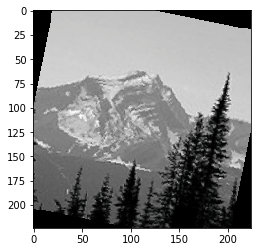

In [61]:
ind = 4

photo = invTrans(torch.from_numpy(conf_images[ind][0]))
photo = np.transpose(photo.numpy(), (1, 2, 0))
plt.imshow(photo)
print(f'Path: {conf_images[ind][1]}')

In [0]:
ind = 0

photo = invTrans(torch.from_numpy(mislabeled[ind][0]))
photo = np.transpose(photo.numpy(), (1, 2, 0))
print(f'Prediction: {mislabeled[ind][1]}\tTarget: {mislabeled[ind][2]}')
plt.imshow(photo)

In [0]:
for _, path in conf_images:
    os.remove(path)

In [0]:
for _, _, _, path in mislabeled:
    os.remove(path)

# Save model to Drive

In [0]:
!cp resnet50intel.pt /content/drive/My\ Drive/

# Try out your own image (Demo)

## Dependencies

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from PIL import Image
from torchvision import transforms, models
%matplotlib inline

## Upload model weights and image

In [0]:
from google.colab import files
files.upload()

In [0]:
transform = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
])

## Evaluate results

In [0]:
class GetProbs:
    def __init__(self, modelpath):
        self.model = torch.load(modelpath).cpu()
    
    def __call__(self, imgpath, plot=True):
        self.model.eval()
        img = Image.open(imgpath)
        preds = self.model(torch.unsqueeze(transform(img), 0))
        x = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
        if(plot):
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(img)
            ax[0].set_title('Original image')
            ax[1].set_title('Predictions')
            ax[1].set_ylabel('Percentage')
            ax[1].set_xlabel('Labels')
            prob = torch.exp(preds)
            prob = torch.div(prob, torch.sum(prob))
            prob = prob.detach().numpy()[0]
            sns.barplot(x=x, y=prob*100, ax=ax[1])
        else:
            pred = x[(torch.max(preds, dim=1))[1].item()]
            return pred

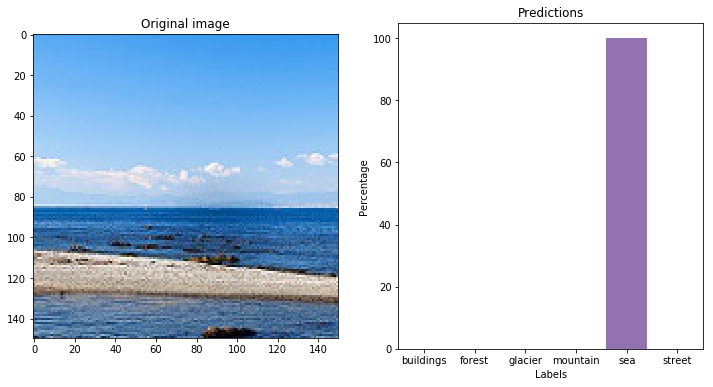

In [217]:
get_probs = GetProbs('drive/My Drive/intelmodel.pt')
get_probs('seg_pred/1003.jpg')

# To get csv for seg_pred folder

In [0]:
preds = []

for f in tqdm(os.listdir('seg_pred')):
    preds.append([f[:-4], get_probs('seg_pred/'+f, plot=False)])

In [0]:
df = pd.DataFrame(data=preds, columns=['ID', 'Class'])

In [0]:
df = df.sort_values('ID')

In [0]:
df.to_csv('preds.csv', index=False)